In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt

from ViTSOM import AutoEncoder, ViTSOMLoss
from help_functions import get_grid_coords, decay_exponential, calculate_purity, capture_latent, plot_umap

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [3]:
config_my = {
    'img_size': 28,
    'patch_size': 4,
    'num_of_channels': 1,
    'embed_dim': 16,
    'enc_depth': 4,
    'dec_depth': 2,
    'num_heads': 2,
    'mlp_dim': 64,
    'som_rows': 5,
    'som_cols': 5,
    'epochs': 20,
    'lr': 1e-3
}

config_paper = {
    'img_size': 28,
    'patch_size': 4,
    'num_of_channels': 1,
    'embed_dim': 16,
    'enc_depth': 4,
    'dec_depth': 2,
    'num_heads': 2,
    'mlp_dim': 64,
    'som_rows': 24,
    'som_cols': 24,
    'epochs': 200,
    'lr': 0.0005,
}

In [4]:
autoencoder = AutoEncoder(img_size=config_paper['img_size'], 
                          patch_size=config_paper['patch_size'], 
                          num_of_channels=config_paper['num_of_channels'], 
                          embed_dim=config_paper['embed_dim'], 
                          enc_depth=config_paper['enc_depth'],                                      
                          dec_depth=config_paper['dec_depth'], 
                          num_heads=config_paper['num_heads'], 
                          mlp_dim=config_paper['mlp_dim'], 
                          som_rows=config_paper['som_rows'], 
                          som_cols=config_paper['som_cols'])    

In [5]:
optimizer = optim.AdamW(autoencoder.parameters(), lr=config_paper['lr'])
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)
criterion = ViTSOMLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=config_paper['epochs'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)
autoencoder.train()

# starting and ending value of sigma, beta is calculated to reach sigma_end at last epoch
sigma_start = config_paper['som_rows'] / 2.0
sigma_end = 0.5
beta = (sigma_end / sigma_start) ** (1 / config_paper['epochs'])

grid_coords = get_grid_coords(config_paper['som_rows'], config_paper['som_cols'], device)
current_sigma = sigma_start

history = {'total': [], 'mse': [], 'som': [], 'purity': []}

checkpoints = [0,25,50,200]
snapshot = {}

snapshot[0] = capture_latent(autoencoder, loader, device)

print("Start training")
for epoch in range(config_paper['epochs']):
    running_loss = 0.0
    running_mse = 0.0
    running_som = 0.0
    
    sigma_t = decay_exponential(sigma_start, beta, epoch)
    
    for images, _ in loader:
        images = images.to(device)
        
        reconstructed, latent = autoencoder(images)
        som_weights = autoencoder.get_som_weights()
        
        total_loss, l_nn, l_som = criterion(images, reconstructed, latent, som_weights, grid_coords, sigma_t)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        running_mse += l_nn.item()
        running_som += l_som.item()
    
    if epoch+1 in checkpoints:
        snapshot[epoch+1] = capture_latent(autoencoder, loader, device)
    
    # updating learning rule through CosineAnnealingLR
    scheduler.step()
    purity = calculate_purity(autoencoder, loader, device)
    
    avg_total = running_loss / len(loader)
    avg_mse = running_mse / len(loader)
    avg_som = running_som / len(loader)
    
    history['total'].append(avg_total)
    history['mse'].append(avg_mse)
    history['som'].append(avg_som)
    history['purity'].append(purity)
    
    print(f"Epoch {epoch+1}/{config_paper['epochs']} | Sigma: {sigma_t:.2f} | "
          f"Loss: {avg_total:.5f} (MSE: {avg_mse:.5f} | SOM: {avg_som:.5f}) | Purity: {purity:.5f}")


Start training
Epoch 1/200 | Sigma: 12.00 | Loss: 204.08807 (MSE: 0.03322 | SOM: 204.05485) | Purity: 0.11237
Epoch 2/200 | Sigma: 11.81 | Loss: 52.81250 (MSE: 0.00401 | SOM: 52.80849) | Purity: 0.11267
Epoch 3/200 | Sigma: 11.62 | Loss: 7.01924 (MSE: 0.00238 | SOM: 7.01686) | Purity: 0.15958
Epoch 4/200 | Sigma: 11.44 | Loss: 1.08430 (MSE: 0.00178 | SOM: 1.08253) | Purity: 0.14440
Epoch 5/200 | Sigma: 11.26 | Loss: 0.11946 (MSE: 0.00120 | SOM: 0.11827) | Purity: 0.14933
Epoch 6/200 | Sigma: 11.08 | Loss: 0.01249 (MSE: 0.00071 | SOM: 0.01178) | Purity: 0.13047
Epoch 7/200 | Sigma: 10.91 | Loss: 0.00113 (MSE: 0.00053 | SOM: 0.00059) | Purity: 0.13502
Epoch 8/200 | Sigma: 10.74 | Loss: 0.00058 (MSE: 0.00047 | SOM: 0.00011) | Purity: 0.12845
Epoch 9/200 | Sigma: 10.57 | Loss: 0.00055 (MSE: 0.00044 | SOM: 0.00010) | Purity: 0.12345
Epoch 10/200 | Sigma: 10.40 | Loss: 0.00054 (MSE: 0.00043 | SOM: 0.00011) | Purity: 0.13040
Epoch 11/200 | Sigma: 10.24 | Loss: 0.00054 (MSE: 0.00042 | SOM: 0.0

KeyboardInterrupt: 

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


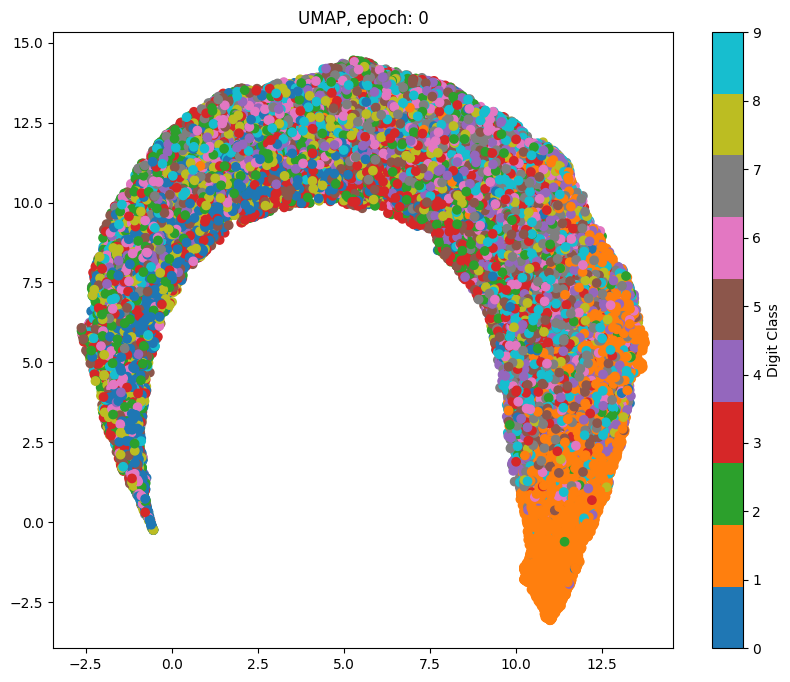

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


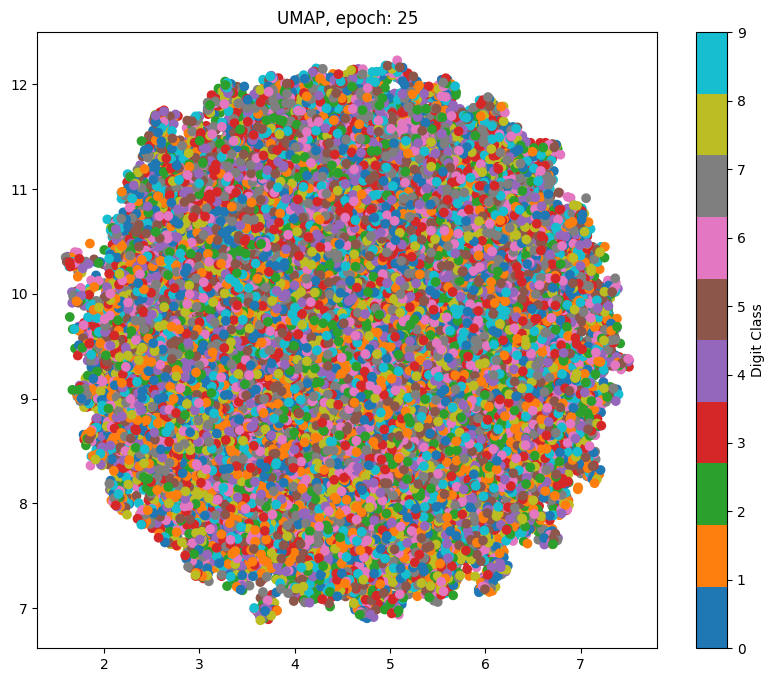

C:\Users\kubha\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


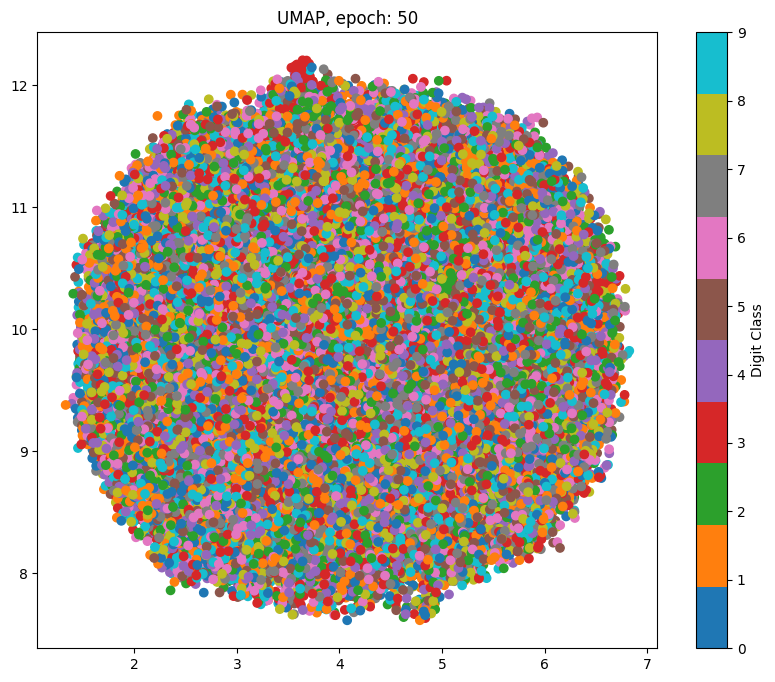

In [6]:
plot_umap(snapshot)